<a href="https://colab.research.google.com/github/Catolampus/Fruit_detection/blob/master/Fruit_detection_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Фреймворк - Pytorch (torchvision.models.detection)

2)Запуск детектора на случайных картинках


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
from PIL import Image
import cv2
from pathlib import Path
from xml.etree import ElementTree
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


--2020-07-12 10:41:46--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227231 (222K) [image/jpeg]
Saving to: ‘800px-Apples.jpg’

800px-Apples.jpg    100%[===================>] 221.91K  --.-KB/s    in 0.05s   

2020-07-12 10:41:46 (4.56 MB/s) - ‘800px-Apples.jpg’ saved [227231/227231]



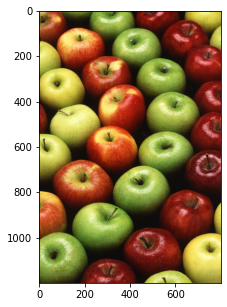

In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
pilimg = Image.open('/content/800px-Apples.jpg')
plt.figure(figsize=(10,5))
plt.imshow(pilimg);

In [4]:
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
predict = model(img)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [5]:
predict

[{'boxes': tensor([[1.8622e+00, 9.7890e+02, 1.9926e+02, 1.1893e+03],
          [6.2868e+02, 9.7439e+02, 8.0000e+02, 1.1912e+03],
          [2.0514e+00, 5.3780e+02, 1.4574e+02, 7.9291e+02],
          [3.6587e+02, 9.5319e+02, 6.2755e+02, 1.1735e+03],
          [5.9498e+01, 6.5246e+02, 3.2540e+02, 8.8298e+02],
          [1.8893e+02, 1.0871e+03, 4.2780e+02, 1.1990e+03],
          [5.2084e+02, 7.8639e+02, 7.7524e+02, 1.0246e+03],
          [2.1300e+02, 5.1986e+02, 4.3193e+02, 7.3710e+02],
          [0.0000e+00, 7.9342e+02, 1.2643e+02, 1.0100e+03],
          [2.1712e+02, 8.4225e-01, 4.2522e+02, 1.6276e+02],
          [1.4348e+02, 8.3421e+02, 4.1672e+02, 1.0928e+03],
          [3.2639e+02, 7.0185e+02, 5.7973e+02, 9.2411e+02],
          [4.1108e+01, 4.1030e+02, 2.7134e+02, 6.3128e+02],
          [4.7382e+02, 3.5824e+02, 7.0240e+02, 5.5567e+02],
          [6.3890e+02, 6.1707e+02, 8.0000e+02, 8.5434e+02],
          [3.0774e+00, 2.5100e+02, 1.9998e+02, 4.3731e+02],
          [2.6334e+02, 3.1949e+

In [6]:
def plot_preds(pilimg, predict):
    numimg = np.array(pilimg)
    boxes = predict[0]['boxes'][predict[0]['scores']>0.8].cpu().detach().numpy()
    labels = predict[0]['labels'][predict[0]['scores']>0.8].cpu().detach().numpy()
    # Переведем метки в названия
    COCO = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    # Отрисовка
    counter=0
    for i in boxes:
        final = cv2.rectangle(numimg, (i[0],i[1]), (i[2],i[3]), color=(128, 0, 128), thickness=3)
        cv2.putText(numimg, str(COCO[labels[counter]]), (i[0],i[1]), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (0,0,0), 2)
        counter+=1
    plt.figure(figsize=(10,5))
    return plt.imshow(final)

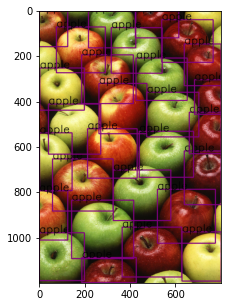

In [7]:
plot_preds(pilimg, predict)

В данном проекте попытаюсь выполнить оба сценария.
Датасет: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection
Детекция фруктов

In [8]:
#Загрузим датасет
import gdown
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM', '34662_46346_bundle_archive.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM
To: /content/34662_46346_bundle_archive.zip
29.7MB [00:00, 131MB/s] 


'34662_46346_bundle_archive.zip'

In [9]:
#Разархивируем датасет с каггла
!unzip -q 34662_46346_bundle_archive.zip

In [10]:
#Кодируем классы
label_code = ['__background__', 'apple', 'orange', 'banana']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
#Меняем количество классов для предсказания
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [12]:
# path = Path('/content')
# _path = path /'train_zip'/'train'
# img_lst = list(sorted(_path.glob("*.jpg")))
# xml_lst = list(sorted(_path.glob("*.xml")))

In [13]:
class FrutDataset (torch.utils.data.Dataset):
    def __init__(self, path, mode):
        self.path = path 
        self.mode = mode
        path = Path(path)
        if mode == "train":
            _path = path /'train_zip'/'train'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        elif mode == "test":
            _path = path/'test_zip'/'test'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        else:
            raise ValueError('Incorrect mode')
    
    def __len__(self):
        return len(self.img_lst)

    def __getitem__(self, index):
        img = self.img_lst[index]
        label = self.xml_lst[index]
        pil = Image.open(img).convert('RGB')
        x = tv.transforms.ToTensor()(pil)
        #Извлечем координаты из xml
        tr = ElementTree.parse(label)
        root = tr.getroot()
        name = []
        coord = []
        labels_code = ['__background__','apple', 'orange', 'banana']
        for element in root.iter('object'):
            tempcoord = []
            for child in element:
                if child.tag == 'name':
                    name += [labels_code.index(child.text)]
                elif child.tag == 'bndbox':
                    for i in child:
                        tempcoord +=[int(i.text)]
                    coord +=[tempcoord]
        coord = torch.LongTensor(coord)
        name = torch.LongTensor(name)
        label = {'boxes':coord , 'labels': name}
        return (x, label)

In [14]:
#Создаем обучающий и валидационный сеты
train_set = FrutDataset(path = '/content', mode='train')
val_set = FrutDataset(path = '/content', mode='test')

In [15]:
def my_collate(batch):
    image = [i[0].to(device) for i in batch]
    target = [i[1] for i in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return image, target

In [16]:
#Загрузчики
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True, collate_fn=my_collate)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                         shuffle=False, collate_fn=my_collate)

In [17]:
optim = torch.optim.AdamW(model.parameters(), amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)

In [18]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [19]:
def train_one_epoch(model, optimizer, train_set):
    model.train()
    save_loss = 0
    for images, targets in train_set:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        save_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'loss for epoch {save_loss}')
    return save_loss

In [87]:
def iou (box_true, box_pred):
    '''
    box_true - [x1,y1,x2,y2]
    box_pred - [x1,y1,x2,y2]
    '''
    x1i = max(box_true[0],box_pred[0])
    y1i = max(box_true[1],box_pred[1])
    x2i = min(box_true[2],box_pred[2])
    y2i = min(box_true[3],box_pred[3])
    intersection = abs(y2i-y1i)*abs(x2i-x1i)
    box_true_area = (box_true[2]-box_true[0])*(box_true[3]-box_true[1])
    box_pred_area = (box_pred[2]-box_pred[0])*(box_pred[3]-box_pred[1])
    union = box_true_area+box_pred_area-intersection
    iou = intersection/union
    return iou

In [92]:
sdgs

10
iou = 0.4166666666666667


In [ ]:
#Цикл обучения
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 10
save_loss = 100
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    # if total_loss < save_loss:
    #     torch.save(model.state_dict(), path_for_save)
    #     save_loss = total_loss
    lr_scheduler.step()

Если ранее уже обучали

In [24]:
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
if Path(path_for_save).exists():
    model.load_state_dict(torch.load(path_for_save, map_location=torch.device('cpu')))

In [25]:
model.eval()
predict = model(img)

In [ ]:
predict

In [32]:
def validation (model, val_loader):
    model.eval()
    with torch.no_grad():
        for x, y_true in val_loader:
            x = x[0].unsqueeze(0)
            y_pred = model(x)[0]
            break
    return y_true, y_pred

In [ ]:
y_true, y_pred = validation (model, val_loader)

8058


1.387157858495438

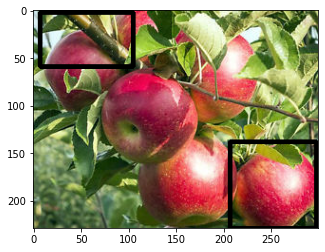

In [103]:
img = Image.open('/content/test_zip/test/apple_77.jpg')
npimg = np.array(img)
x= [207, 138, 298, 229]
y= [7,2,105,59]
final = cv2.rectangle(npimg, (x[0],x[1]), (x[2],x[3]), color=(0, 0, 0), thickness=3)
final = cv2.rectangle(npimg, (y[0],y[1]), (y[2],y[3]), color=(0, 0, 0), thickness=3)
plt.imshow(final)
iou(x, y)

In [93]:
y_true

[{'boxes': tensor([[ 71,  60, 175, 164],
          [ 12,  22, 105, 111],
          [134,  23, 243, 115],
          [107, 126, 216, 229],
          [207, 138, 298, 229]]), 'labels': tensor([1, 1, 1, 1, 1])}]

In [94]:
y_pred

{'boxes': tensor([[109.0878, 127.6724, 219.4743, 225.3870],
         [210.2774, 147.2245, 300.0000, 229.0000],
         [ 73.8039,  63.7614, 169.8919, 172.9173],
         [ 85.5547,   0.3423, 133.7070,  44.8154],
         [  7.9712,  22.8405,  94.0832,  95.5597],
         [ 89.5758,  36.7280, 263.6698, 199.5987],
         [ 89.1522,  83.9903, 214.7829, 208.8386],
         [148.3787,  29.4646, 239.6984, 111.6082],
         [ 13.1450,  44.2925,  78.5362, 107.2399],
         [147.4521,  61.4315, 230.7689, 123.0086],
         [126.8352,  12.9905, 271.9237, 122.9586],
         [174.3713, 113.2269, 271.8626, 167.3492],
         [184.1665, 123.1217, 283.6619, 216.4128],
         [  7.5638,  28.7330, 104.5223, 184.3779],
         [ 28.3308,  86.0000, 107.6439, 182.0970],
         [143.9449, 139.7957, 255.9070, 225.2264],
         [ 52.9557,  36.2863, 204.6720, 168.8798],
         [ 53.7442,   0.0000,  91.5024,  30.6566],
         [107.4488,  54.6809, 214.8114, 129.7401],
         [ 56.1806,  8

In [104]:
for i in torch.unique(y_pred['labels']):
    FN = 0
    iou_lst = []
    pred_boxes = y_pred['boxes'][y_pred['labels']==i]#[y_pred['scores']>0.5]
    true_boxes = y_true[0]['boxes'][y_true[0]['labels']==i]
    print(true_boxes)
    if len(true_boxes) == 0:
        FN += len(pred_boxes)
        continue
    for t_box in true_boxes:
        for p_box in pred_boxes:
            iou_lst +=[iou(t_box,p_box)]
    
    print(iou_lst)
    print('max v liste', max(iou_lst))
    print('min v liste', min(iou_lst))

tensor([[ 71,  60, 175, 164],
        [ 12,  22, 105, 111],
        [134,  23, 243, 115],
        [107, 126, 216, 229],
        [207, 138, 298, 229]])
tensor(2394.4324)
tensor(591.7939)
tensor(9631.7236)
tensor(731.1741)
tensor(820.8335)
tensor(8884.1143)
tensor(6868.6533)
tensor(1373.8759)
tensor(356.0080)
tensor(1696.3203)
tensor(3032.3884)
tensor(31.9191)
tensor(374.7094)
tensor(3486.3232)
tensor(2858.2258)
tensor(751.6668)
tensor(10816)
tensor(601.6100)
tensor(4711.0244)
tensor(999.4403)
tensor(25.8261)
tensor(6181.0669)
tensor(26.9052)
tensor(617.2396)
tensor(20.8129)
tensor(756.2876)
tensor(68.1531)
tensor(3813.6252)
tensor(1473.6575)
tensor(443.6525)
tensor(5969.0308)
tensor(1145.5837)
tensor(428.0437)
tensor(3536.9036)
tensor(4116.2021)
tensor(2104.2844)
tensor(1943.3359)
tensor(154.4803)
tensor(959.6362)
tensor(7611.5342)
tensor(1916.7318)
tensor(1121.4458)
tensor(3888.4250)
tensor(326.8556)
tensor(137.9164)
tensor(753.1864)
tensor(1722.8555)
tensor(3442.1970)
tensor(3462.4312